In [198]:
import numpy as np
import pandas as pd

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [199]:
train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

In [200]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [201]:
def bar_chart(feature):
    T_true = train[train['Transported']==1][feature].value_counts()
    T_false = train[train['Transported']==0][feature].value_counts()
    df = pd.DataFrame([T_true, T_false])
    df.index = ['True','False']
    df.plot(kind='bar',stacked=True, figsize=(10,5))

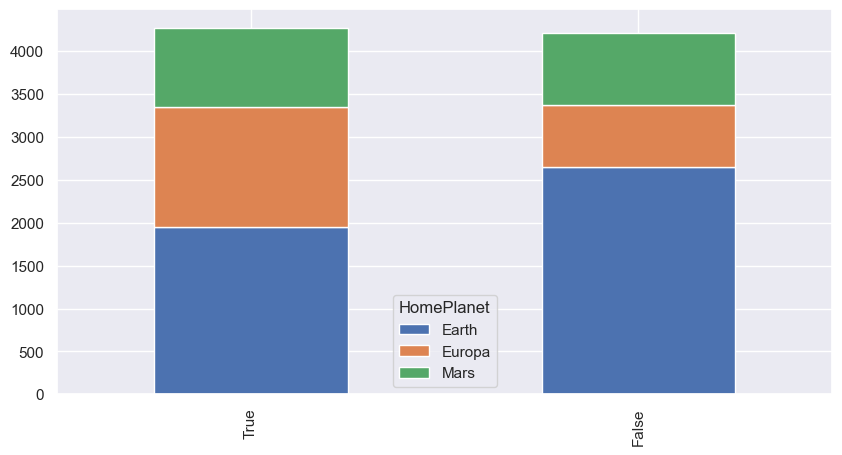

In [202]:
bar_chart('HomePlanet')

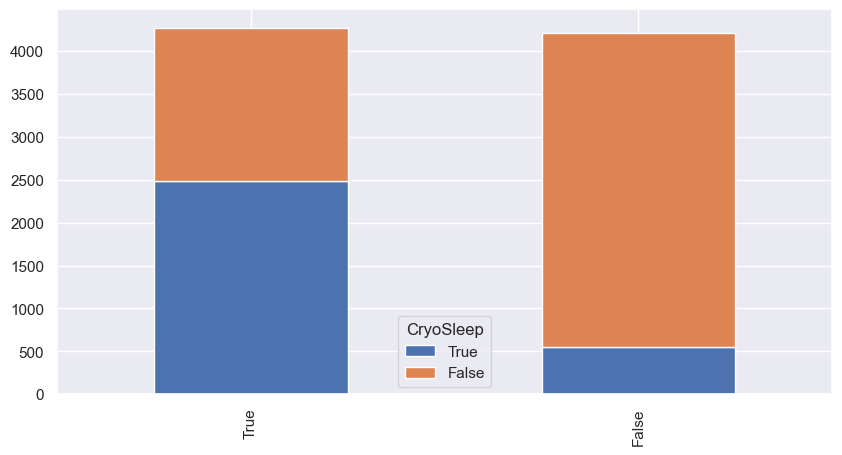

In [203]:
bar_chart('CryoSleep')

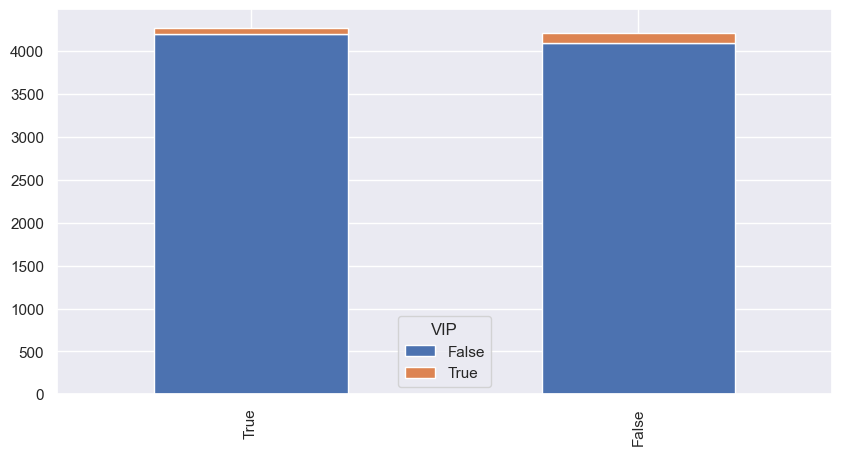

In [204]:
bar_chart('VIP')

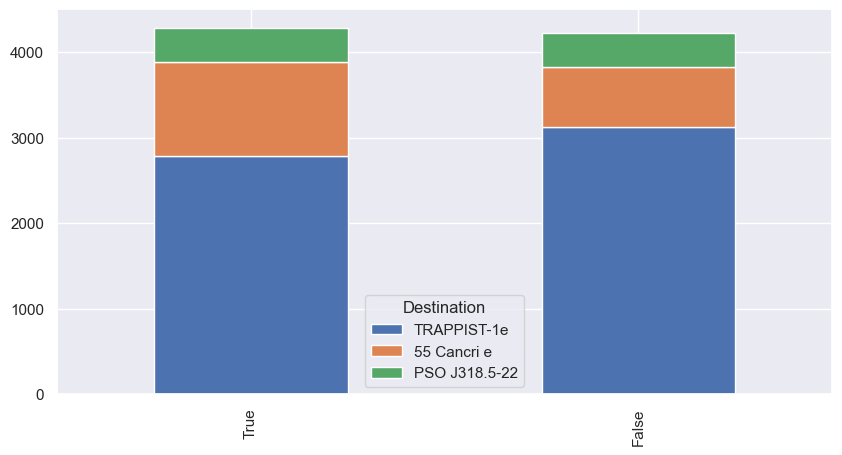

In [205]:
bar_chart('Destination')

In [206]:
trNte = [train, test]

for data in trNte:
    data['Age'] = data['Age'].fillna(data['Age'].mean())
    
    data.loc[data['Age'] < 8, 'Age'] = 0
    data.loc[(data['Age'] >= 8) & (data['Age'] < 20), 'Age'] = 1
    data.loc[(data['Age'] >= 20) & (data['Age'] < 36), 'Age'] = 2
    data.loc[(data['Age'] >= 36) & (data['Age'] < 55), 'Age'] = 3
    data.loc[data['Age'] >= 55, 'Age'] = 4
    
    data[['Deck', 'Num', 'Side']] = data['Cabin'].str.split('/', expand=True)
    
    data['CryoSleep'] = data['CryoSleep'].fillna(False)
    data['HomePlanet'] = data['HomePlanet'].fillna('Earth')
    data['Deck'] = data['Deck'].fillna('F')
    data['Side'] = data['Side'].fillna('S')
    data['Destination'] = data['Destination'].fillna('TRAPPIST-1e')
    data['VIP'] = data['VIP'].fillna(False)
    data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] =\
        data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0)
    
    data[['CryoSleep', 'VIP']] = data[['CryoSleep', 'VIP']].astype(int)

In [207]:
HP_map = {'Earth':0, 'Europa':1, 'Mars':2}
D_map = {'TRAPPIST-1e':0, '55 Cancri e':1, 'PSO J318.5-22':2}
S_map = {'P':0, 'S':1}
De_map = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'T':7}

train['HomePlanet'] = train['HomePlanet'].map(HP_map)
train['Destination'] = train['Destination'].map(D_map)
train['Side'] = train['Side'].map(S_map)
train['Deck'] = train['Deck'].map(De_map)

train['Transported'] = train['Transported'].astype(int)

test['HomePlanet'] = test['HomePlanet'].map(HP_map)
test['Destination'] = test['Destination'].map(D_map)
test['Side'] = test['Side'].map(S_map)
test['Deck'] = test['Deck'].map(De_map)

In [208]:
train = train.drop(labels=['PassengerId', 'Cabin', 'Num', 'Name'], axis=1)
test = test.drop(labels=['Cabin', 'Num', 'Name'], axis=1)

In [209]:
train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Side
0,1,0,0,3.0,0,0.0,0.0,0.0,0.0,0.0,0,1,0
1,0,0,0,2.0,0,109.0,9.0,25.0,549.0,44.0,1,5,1
2,1,0,0,4.0,1,43.0,3576.0,0.0,6715.0,49.0,0,0,1
3,1,0,0,2.0,0,0.0,1283.0,371.0,3329.0,193.0,0,0,1
4,0,0,0,1.0,0,303.0,70.0,151.0,565.0,2.0,1,5,1


In [210]:
test.isnull().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Deck            0
Side            0
dtype: int64

In [211]:
train.isnull().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
Deck            0
Side            0
dtype: int64

In [212]:
train['Deck'].value_counts()

Deck
5    2993
6    2559
4     876
1     779
2     747
3     478
0     256
7       5
Name: count, dtype: int64

In [213]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score

In [215]:
train_data = train.drop('Transported', axis=1)
target = train['Transported']

test_data = test.drop('PassengerId', axis=1).copy()
Id = test['PassengerId']

In [216]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

clf = RandomForestClassifier()
score = cross_val_score(clf, train_data, target, cv=k_fold, n_jobs=2)

print(score)

[0.7862069  0.79770115 0.79310345 0.81242808 0.76754891 0.79286536
 0.79516686 0.81127733 0.78481013 0.79171461]


In [217]:
round(np.mean(score)*100, 2)

79.33

In [218]:
clf.fit(train_data, target)
prediction = clf.predict(test_data)

print(prediction)

[1 0 1 ... 1 1 1]
